In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../../dataset/data3b.txt'
data0Label = r'../../../dataset/data3blabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

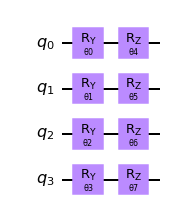

In [6]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

ansatz.draw('mpl')

# SGD optimizer

## Learning Rate =4

In [7]:
learningR=[round(((i+1)/10)**2,2) for i in range(20)]

    
output_shape=2;
epochs = 10     # set number of epochs

model=[];
lossLR=[];



for l in learningR:
    np.random.seed(2)  
    qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                      interpret=parity, output_shape=output_shape, quantum_instance=qi)
    initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
    # set up PyTorch module
    model2 = TorchConnector(qnn2, initial_weights)
    # define optimizer and loss function
    optimizer = optim.SGD(model2.parameters(),lr=l)
    f_loss = MSELoss(reduction='mean')

    # start training
    model2.train()   # set model to training mode
    
    print("Learning Rate is ", l)
    # define objective function
    for epoch in range(epochs):
        optimizer.zero_grad()        # initialize gradient
        loss = 0.0                                             # initialize loss    
        for x, y_target in zip(X, y01):                        # evaluate batch loss
            output = model2(Tensor(x)).reshape(1, 2)           # forward pass
            targets=Tensor([y_target]).long()
            targets = targets.to(torch.float32)
            #targets = targets.unsqueeze(1)
            loss += f_loss(output, targets) 
        loss.backward()                              # backward pass
        print("__Loss is ",loss.item())                           # print loss

        # run optimizer
        optimizer.step() 
    model.append(model2)
    lossLR.append(loss.item())


Learning Rate is  0.01


C:\Users\Saesun Kim\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


__Loss is  28.600173950195312
__Loss is  27.411035537719727
__Loss is  26.68559455871582
__Loss is  26.230384826660156
__Loss is  25.932811737060547
__Loss is  25.730098724365234
__Loss is  25.58674430847168
__Loss is  25.48201560974121
__Loss is  25.40333366394043
__Loss is  25.3427734375
Learning Rate is  0.04
__Loss is  28.600173950195312
__Loss is  25.45770835876465
__Loss is  25.21772003173828
__Loss is  25.133602142333984
__Loss is  25.09248161315918
__Loss is  25.06877899169922
__Loss is  25.053695678710938
__Loss is  25.043428421020508
__Loss is  25.03609275817871
__Loss is  25.030656814575195
Learning Rate is  0.09
__Loss is  28.600173950195312
__Loss is  25.015945434570312
__Loss is  25.013591766357422
__Loss is  25.011993408203125
__Loss is  25.01087188720703
__Loss is  25.01008415222168
__Loss is  25.009517669677734
__Loss is  25.009103775024414
__Loss is  25.00881004333496
__Loss is  25.008586883544922
Learning Rate is  0.16
__Loss is  28.600173950195312
__Loss is  27.9511

Learning Rate: 0.01 loss: 25.3427734375  Accuracy: 0.54
Learning Rate: 0.04 loss: 25.030656814575195  Accuracy: 0.62
Learning Rate: 0.09 loss: 25.008586883544922  Accuracy: 0.8
Learning Rate: 0.16 loss: 25.014738082885742  Accuracy: 0.66
Learning Rate: 0.25 loss: 25.029932022094727  Accuracy: 0.57
Learning Rate: 0.36 loss: 25.008243560791016  Accuracy: 0.79
Learning Rate: 0.49 loss: 25.00838851928711  Accuracy: 0.78
Learning Rate: 0.64 loss: 27.338329315185547  Accuracy: 0.52
Learning Rate: 0.81 loss: 30.14754867553711  Accuracy: 0.6
Learning Rate: 1.0 loss: 26.29821014404297  Accuracy: 0.45
Learning Rate: 1.21 loss: 33.2520751953125  Accuracy: 0.46
Learning Rate: 1.44 loss: 38.56826400756836  Accuracy: 0.46
Learning Rate: 1.69 loss: 25.026796340942383  Accuracy: 0.56
Learning Rate: 1.96 loss: 26.316450119018555  Accuracy: 0.54
Learning Rate: 2.25 loss: 36.9927864074707  Accuracy: 0.46
Learning Rate: 2.56 loss: 26.0288143157959  Accuracy: 0.46
Learning Rate: 2.89 loss: 25.4131546020507

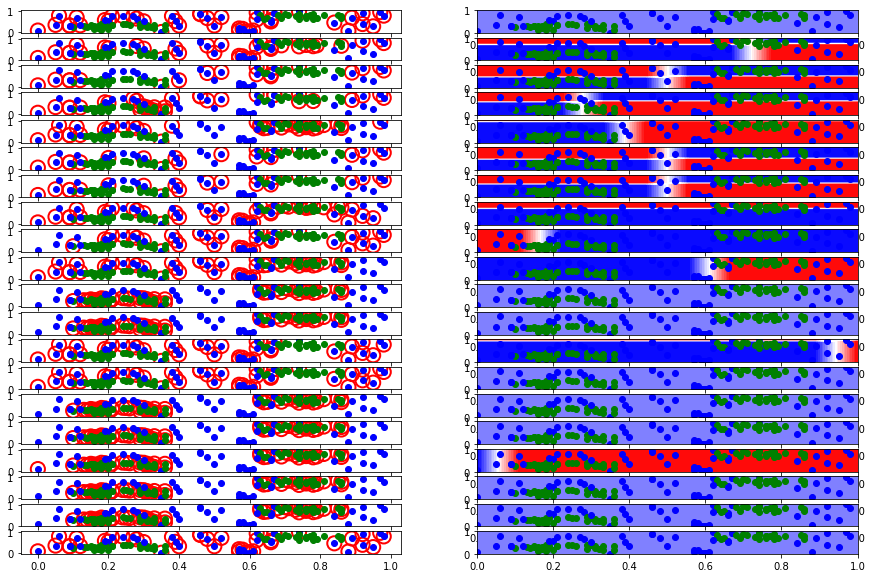

In [8]:
ln=len(learningR)
fig = plt.figure(figsize=(15, 10))
accLR=[];
for lr in range(ln):

    ax = fig.add_subplot(ln, 2, 2*lr+1)
    y_predict = []
    for x in X:
        output = model[lr](Tensor(x))
        y_predict += [np.argmax(output.detach().numpy())]
    acc=sum(y_predict == np.array(y01))/len(np.array(y01))
    print('Learning Rate:', learningR[lr],'loss:',lossLR[lr],' Accuracy:', acc)
    accLR.append(acc)
    # plot results
    # red == wrongly classified
    for x, y_target, y_ in zip(X, y01, y_predict):
        if y_target == 1:
            ax.plot(x[0], x[1], 'bo')
        else:
            ax.plot(x[0], x[1], 'go')
        if y_target != y_:
            ax.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)


    ax = fig.add_subplot(ln, 2, 2*lr+2)
    for x, y_target, y_ in zip(X, y01, y_predict):
        if y_target == 1:
            ax.plot(x[0], x[1], 'bo')
        else:
            ax.plot(x[0], x[1], 'go')

    X1 = np.linspace(0, 1, num=10)
    Z1 = np.zeros((len(X1), len(X1)))

    # Contour map
    for j in range(len(X1)):
        for k in range(len(X1)):
            # Fill Z with the labels (numerical values)
            # the inner loop goes over the columns of Z,
            # which corresponds to sweeping x-values
            # Therefore, the role of j,k is flipped in the signature
            Z1[j, k] = np.argmax(model[lr](Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())

    ax.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [9]:
f1=fig
f1.set_size_inches(10, 80)
f1.savefig('SGD_3b.png')

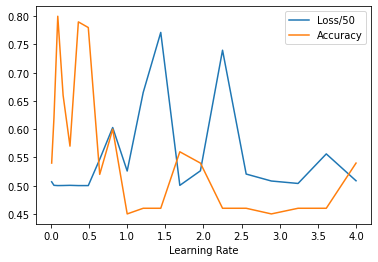

In [10]:
lossLR50=[x/50 for x in lossLR]
plt.plot(learningR,lossLR50, label = "Loss/50")
plt.plot(learningR,accLR, label = "Accuracy")
plt.xlabel('Learning Rate')
plt.legend()
plt.show()

In [11]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
lvA=[[learningR[x],accLR[x]] for x in range(len(accLR))]
np.savetxt("SGD_Accuracy_3b.txt",lvA,fmt='%.2f')

In [12]:
max(accLR)

0.8